In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 244 kB/s 


In [ ]:
#importing libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, BatchNormalization, ReLU, PReLU, UpSampling3D, Input, Concatenate, Add, Conv2D, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import SimpleITK as sitk
seed = 1

In [ ]:
# Defining Custom Metrics

from tensorflow.keras import backend as K

def recall(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (actual_positives + K.epsilon())
  return recall

def precision(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1score(y_true, y_pred):
  P = precision(y_true, y_pred)
  R = recall(y_true, y_pred)
  return 2*((P*R)/(P+R+K.epsilon()))

In [ ]:
# Defining Losses based on Dice & IoU

class CustomLoss(tf.keras.losses.Loss):
    
    def __init__(self, smooth=1e-6, gamma=2):
        super(CustomLoss, self).__init__()
        self.smooth = smooth
        self.gamma = gamma

    def dice_loss(self, y_true, y_pred):
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        numerator = 2*tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(y_pred ** self.gamma) + tf.reduce_sum(y_true ** self.gamma) + self.smooth
        dice = tf.divide(numerator, denominator)
        return 1 - dice

    def iou_loss(self, y_true, y_pred):
        dice = 1 - self.dice_loss(y_true, y_pred)
        iou = dice/(2-dice)
        return 1 - iou

custom_loss = CustomLoss()

##Tumor Segmentation

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, data_path, batch_size, input_size=(96, 96, 96, 1), modality='all'):
        self.data_path = data_path
        self.batch_size = batch_size
        self.input_size = input_size
        self.modality = modality
        self.n = len(os.listdir(self.data_path+'/'+self.modality+'/'))

    def on_epoch_end(self):
        pass
    
    def input_process(self, img):
        img = img.astype('float32')
        img = img/255
        #img = (img-img.mean())/img.std() #standardization
        #img = tf.image.resize(img, self.input_size)
        #Crop Central part of image of size self.input_size
        img = img[:, img.shape[1]//2-self.input_size[1]//2:img.shape[1]//2+self.input_size[1]//2, img.shape[2]//2-self.input_size[2]//2:img.shape[2]//2+self.input_size[2]//2]
        #resize image in Z dimension
        img = np.resize(img, (self.input_size[0], img.shape[1], img.shape[2]))
        return img
    
    def output_process(self, img):
        img = img.astype('float32')
        #img = img/255
        img[img!=0] = 1
        #img = (img-img.mean())/img.std() #standardization
        #img = tf.image.resize(img, self.input_size)
        #Crop Central part of image of size self.input_size
        img = img[:, img.shape[1]//2-self.input_size[1]//2:img.shape[1]//2+self.input_size[1]//2, img.shape[2]//2-self.input_size[2]//2:img.shape[2]//2+self.input_size[2]//2]
        #resize image in Z dimension
        img = np.resize(img, (self.input_size[0], img.shape[1], img.shape[2]))
        return img

    def __getitem__(self, index):
        X = []
        Y = []
        if self.modality == 'all':
            X_temp = []
            imgs = os.listdir(self.data_path+'/T1/')
            batches = imgs[index*self.batch_size:(index+1)*self.batch_size]
            modalities = ['T1', 'T1c', 'T2', 'Flair']
            for i in range(len(batches)):
                for modality in modalities:
                    brain_name = self.data_path+'/'+modality+'/'+batches[i]
                    brain_img = sitk.ReadImage(brain_name)
                    brain_img = sitk.GetArrayFromImage(brain_img)
                    brain_img = self.input_process(brain_img)
                    X_temp.append(brain_img)
                X.append(X_temp)
                X_temp = []
                tumor_name = self.data_path+'/OT/'+batches[i]
                tumor_img = sitk.ReadImage(tumor_name)
                tumor_img = sitk.GetArrayFromImage(tumor_img)
                tumor_img = self.output_process(tumor_img)
                Y.append(tumor_img)
        else:
            imgs = os.listdir(self.data_path+'/'+self.modality+'/')
            batches = imgs[index*self.batch_size:(index+1)*self.batch_size]
            for i in range(len(batches)):
                brainname = self.data_path+self.modality+'/'+batches[i]
                tumorname = self.data_path+self.modality+'/'+batches[i]
                brain_img = sitk.ReadImage(brainname)
                brain_img = sitk.GetArrayFromImage(brain_img)
                brain_img = self.input_process(brain_img)
                tumor_img = sitk.ReadImage(tumorname)
                tumor_img = sitk.GetArrayFromImage(tumor_img)
                tumor_img = self.output_process(tumor_img)
                X.append(brain_img)
                Y.append(tumor_img)
        return np.array(X), np.array(Y)
    
    def __len__(self):
        return self.n // self.batch_size

###BRATS 2015 Models

Exact Replica of paper having strided convolutions

In [ ]:
#Define Model
inputs = Input((128, 144, 160, 1))
conv1 = Conv3D(8, 3, padding='same',kernel_initializer='he_normal')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = PReLU()(conv1)

#Contracting 1
cont_1_1 = Conv3D(16, 3, padding='same',strides=(2,2,2),kernel_initializer='he_normal')(conv1)
cont_1_2 = BatchNormalization()(cont_1_1)
cont_1_2 = PReLU()(cont_1_2)
cont_1_2 = Conv3D(16, 3, padding='same',kernel_initializer='he_normal')(cont_1_2)
cont_1_2 = Add()([cont_1_1, cont_1_2])
cont_1_2 = BatchNormalization()(cont_1_2)
cont_1_2 = PReLU()(cont_1_2)

#Contracting 3
cont_3_1 = Conv3D(64, 3, padding='same',strides=(2,2,2),kernel_initializer='he_normal')(cont_1_2)
cont_3_2 = BatchNormalization()(cont_3_1)
cont_3_2 = PReLU()(cont_3_2)
cont_3_2 = Conv3D(64, 3, padding='same',kernel_initializer='he_normal')(cont_3_2)
cont_3_2 = Add()([cont_3_1, cont_3_2])
cont_3_2 = BatchNormalization()(cont_3_2)
cont_3_2 = PReLU()(cont_3_2)

#Expanding 2
exp_2 = Conv3D(16,1,padding='same',kernel_initializer='he_normal')(cont_3_2)
exp_2 = BatchNormalization()(exp_2)
exp_2 = PReLU()(exp_2)
exp_2 = UpSampling3D(size=(2,2,2))(exp_2)
exp2 = BatchNormalization()(exp_2)
exp2 = PReLU()(exp2)
exp2 = Concatenate()([exp2, cont_1_2])
exp2 = Conv3D(32, 3, padding='same',kernel_initializer='he_normal')(exp2)
exp2 = BatchNormalization()(exp2)
exp2 = PReLU()(exp2)

#Expanding 3
exp_3 = Conv3D(8,1,padding='same',kernel_initializer='he_normal')(exp2)
exp_3 = BatchNormalization()(exp_3)
exp_3 = PReLU()(exp_3)
exp_3 = UpSampling3D(size=(2,2,2))(exp_3)
exp3 = BatchNormalization()(exp_3)
exp3 = PReLU()(exp3)
exp3 = Concatenate()([exp3, conv1])
exp3 = Conv3D(16, 3, padding='same',kernel_initializer='he_normal')(exp3)
exp3 = BatchNormalization()(exp3)
exp3 = PReLU()(exp3)

#Output

path2 = Conv3D(1, 1, padding='same',kernel_initializer='he_normal')(exp2)
path12 = UpSampling3D(size=(2,2,2))(path2)
path3 = Conv3D(1, 1, padding='same',kernel_initializer='he_normal')(exp3)
path123 = Add()([path12, path3])
path123 = Softmax()(path123)

model2 = Model(inputs=inputs, outputs=path123)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 144, 1  0           []                               
                                60, 1)]                                                           
                                                                                                  
 conv3d_16 (Conv3D)             (None, 128, 144, 16  224         ['input_2[0][0]']                
                                0, 8)                                                             
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 144, 16  32         ['conv3d_16[0][0]']              
 ormalization)                  0, 8)                                                       

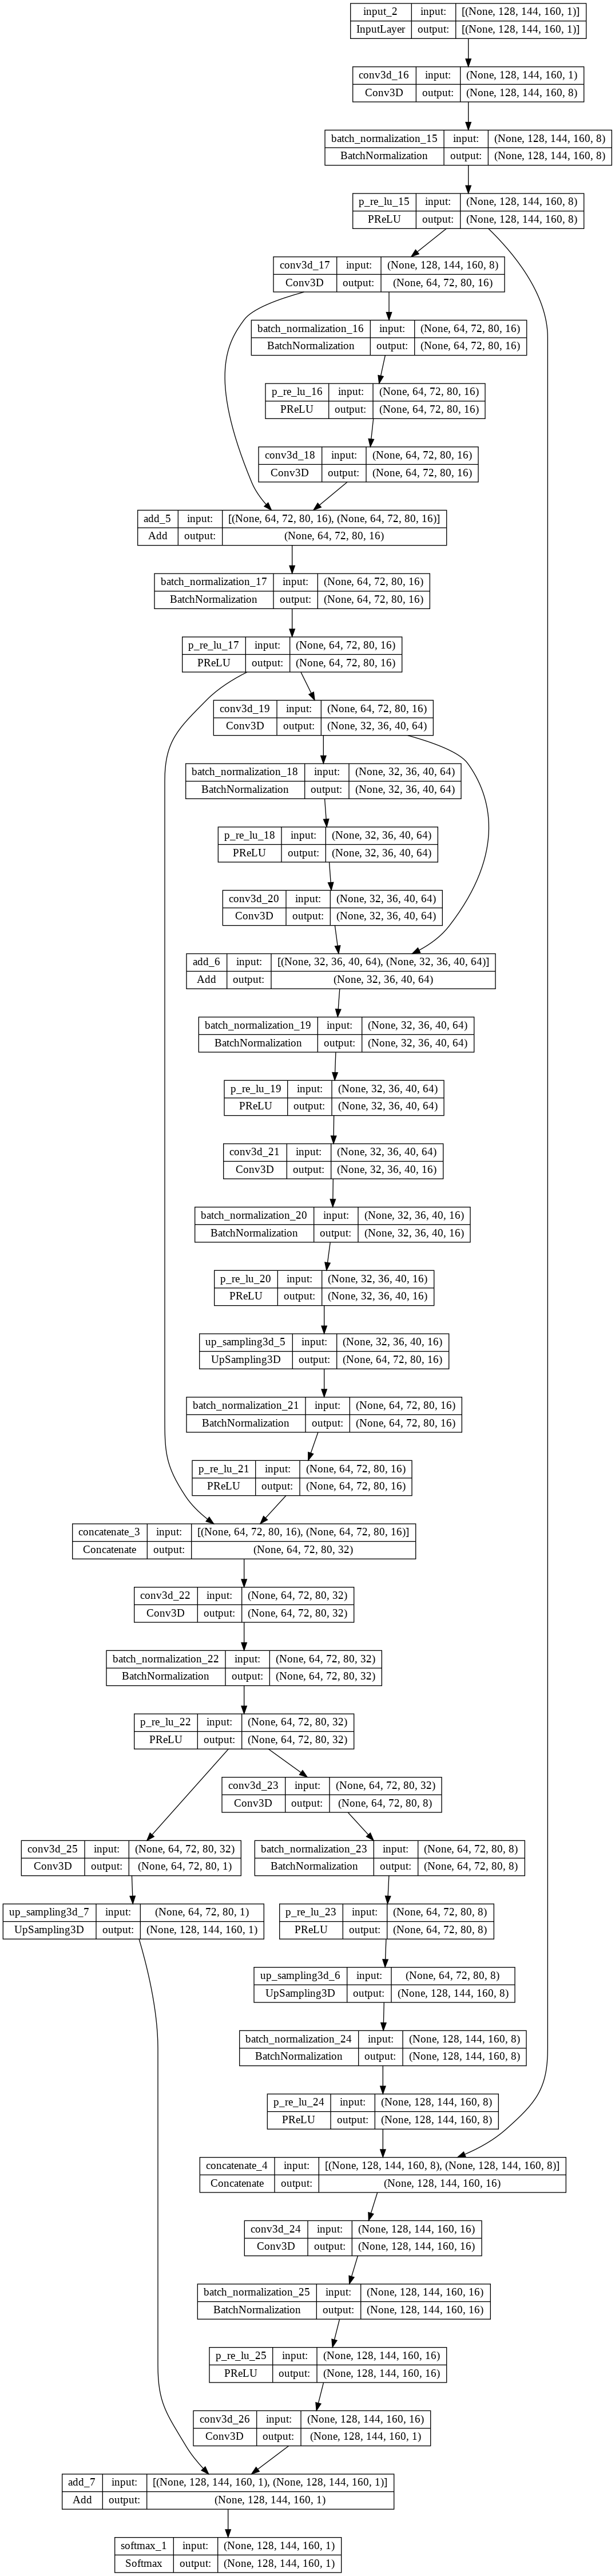

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True)

Model employing maxpooling with few layers shifted across blocks

In [ ]:
#Define Model
inputs = Input((96, 144, 144, 1))
conv1 = Conv3D(8, 3, padding='same')(inputs)

#Contracting 1
cont_1_1 = BatchNormalization()(conv1)
cont_1_1 = PReLU()(cont_1_1)
cont_1_1 = MaxPooling3D()(cont_1_1)
cont_1_1 = Conv3D(16, 3, padding='same')(cont_1_1)
cont_1_2 = BatchNormalization()(cont_1_1)
cont_1_2 = PReLU()(cont_1_2)
cont_1_2 = Conv3D(16, 3, padding='same')(cont_1_2)
cont_1_2 = Add()([cont_1_1, cont_1_2])

#Contracting 2
cont_2_1 = BatchNormalization()(cont_1_2)
cont_2_1 = PReLU()(cont_2_1)
cont_2_1 = MaxPooling3D()(cont_2_1)
cont_2_1 = Conv3D(32, 3, padding='same')(cont_2_1)
cont_2_2 = BatchNormalization()(cont_2_1)
cont_2_2 = PReLU()(cont_2_2)
cont_2_2 = Conv3D(32, 3, padding='same')(cont_2_2)
cont_2_2 = Add()([cont_2_1, cont_2_2])

#Contracting 3
cont_3_1 = BatchNormalization()(cont_2_2)
cont_3_1 = PReLU()(cont_3_1)
cont_3_1 = MaxPooling3D()(cont_2_2)
cont_3_1 = Conv3D(64, 3, padding='same')(cont_3_1)
cont_3_2 = BatchNormalization()(cont_3_1)
cont_3_2 = PReLU()(cont_3_2)
cont_3_2 = Conv3D(64, 3, padding='same')(cont_3_2)
cont_3_2 = Add()([cont_3_1, cont_3_2])

#Expanding 1
exp_1 = Conv3D(32,1,padding='same')(cont_3_2)
exp_1 = BatchNormalization()(exp_1)
exp_1 = PReLU()(exp_1)
exp_1 = UpSampling3D(size=(2,2,2))(exp_1)
exp1 = BatchNormalization()(exp_1)
exp1 = PReLU()(exp1)
exp1 = Concatenate()([exp1, cont_2_2])

#Expanding 2
exp_2_1 = Conv3D(64, 3, padding='same')(exp1)
exp_2_1 = BatchNormalization()(exp_2_1)
exp_2_1 = PReLU()(exp_2_1)
exp_2 = Conv3D(16,1,padding='same')(exp_2_1)
exp_2 = BatchNormalization()(exp_2)
exp_2 = PReLU()(exp_2)
exp_2 = UpSampling3D(size=(2,2,2))(exp_2)
exp2 = BatchNormalization()(exp_2)
exp2 = PReLU()(exp2)
exp2 = Concatenate()([exp2, cont_1_2])

#Expanding 3
exp_3_1 = Conv3D(32, 3, padding='same')(exp2)
exp_3_1 = BatchNormalization()(exp_3_1)
exp_3_1 = PReLU()(exp_3_1)
exp_3 = Conv3D(8,1,padding='same')(exp_3_1)
exp_3 = BatchNormalization()(exp_3)
exp_3 = PReLU()(exp_3)
exp_3 = UpSampling3D(size=(2,2,2))(exp_3)
exp3 = BatchNormalization()(exp_3)
exp3 = PReLU()(exp3)
exp3 = Concatenate()([exp3, conv1])

conv2 = Conv3D(16, 3, padding='same')(exp3)
conv2 = BatchNormalization()(conv2)
conv2 = PReLU()(conv2)

#Output
path1 = Conv3D(1, 1, padding='same')(exp_2_1)
path1 = UpSampling3D(size=(2,2,2))(path1)

path2 = Conv3D(1, 1, padding='same')(exp_3_1)

path3 = Conv3D(1, 1, padding='same')(conv2)

path12 = Add()([path1, path2])
path12 = UpSampling3D(size=(2,2,2))(path12)

path123 = Add()([path12, path3])
path123 = Softmax()(path123)

model1 = Model(inputs=inputs, outputs=path123)
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 96, 144, 14  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d_72 (Conv3D)             (None, 96, 144, 144  224         ['input_5[0][0]']                
                                , 8)                                                              
                                                                                                  
 batch_normalization_68 (BatchN  (None, 96, 144, 144  32         ['conv3d_72[0][0]']              
 ormalization)                  , 8)                                                        

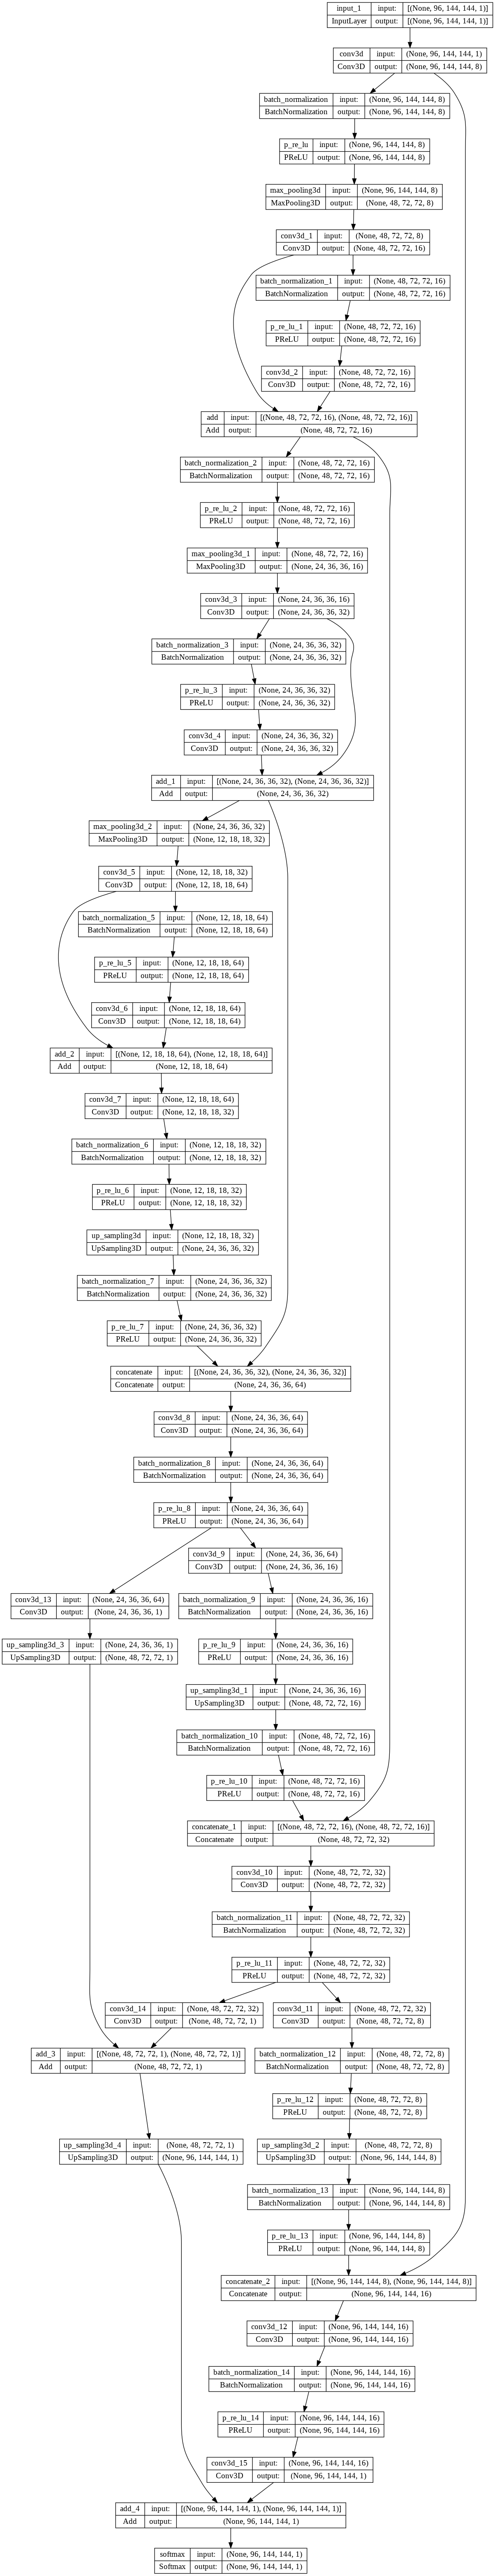

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True)

###BRATS 2020 Model

In [ ]:
inp = Input(shape=(96, 144, 144, 1))

conv1 = Conv3D(48, 3, padding='same')(inp)
conv1 = BatchNormalization()(conv1)
conv1 = ReLU()(conv1)
conv1 = Conv3D(48, 3, padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = ReLU()(conv1)

pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
conv2 = Conv3D(96, 3, padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = ReLU()(conv2)
conv2 = Conv3D(96, 3, padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = ReLU()(conv2)

pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
conv3 = Conv3D(192, 3, padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = ReLU()(conv3)
conv3 = Conv3D(192, 3, padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = ReLU()(conv3)

pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
conv4 = Conv3D(384, 3, padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = ReLU()(conv4)
conv4 = Conv3D(384, 3, padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = ReLU()(conv4)

dil1 = Conv3D(384, 3, dilation_rate=2, padding='same')(conv4)
dil1 = BatchNormalization()(dil1)
dil1 = ReLU()(dil1)
dil1 = Conv3D(384, 3, dilation_rate=2, padding='same')(dil1)
dil1 = BatchNormalization()(dil1)
dil1 = ReLU()(dil1)

conc1 = Concatenate()([conv4, dil1])
conv5 = Conv3D(192, 3, padding='same')(conc1)
conv5 = BatchNormalization()(conv5)
conv5 = ReLU()(conv5)

up1 = UpSampling3D(size=(2, 2, 2))(conv5)
conc2 = Concatenate()([conv3, up1])
conv6 = Conv3D(192, 3, padding='same')(conc2)
conv6 = BatchNormalization()(conv6)
conv6 = ReLU()(conv6)
conv6 = Conv3D(96, 3, padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = ReLU()(conv6)

up2 = UpSampling3D(size=(2, 2, 2))(conv6)
conc3 = Concatenate()([conv2, up2])
conv7 = Conv3D(96, 3, padding='same')(conc3)
conv7 = BatchNormalization()(conv7)
conv7 = ReLU()(conv7)
conv7 = Conv3D(48, 3, padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = ReLU()(conv7)

up3 = UpSampling3D(size=(2, 2, 2))(conv7)
conc4 = Concatenate()([conv1, up3])
conv8 = Conv3D(48, 3, padding='same')(conc4)
conv8 = BatchNormalization()(conv8)
conv8 = ReLU()(conv8)
conv8 = Conv3D(48, 3, padding='same')(conv8)
conv8 = BatchNormalization()(conv8)
conv8 = ReLU()(conv8)

out = Conv3D(1, 1, activation='sigmoid')(conv8)

model3 = tf.keras.Model(inputs=inp, outputs=out)
model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 144, 14  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d_106 (Conv3D)            (None, 96, 144, 144  1344        ['input_7[0][0]']                
                                , 48)                                                             
                                                                                                  
 batch_normalization_100 (Batch  (None, 96, 144, 144  192        ['conv3d_106[0][0]']             
 Normalization)                 , 48)                                                       

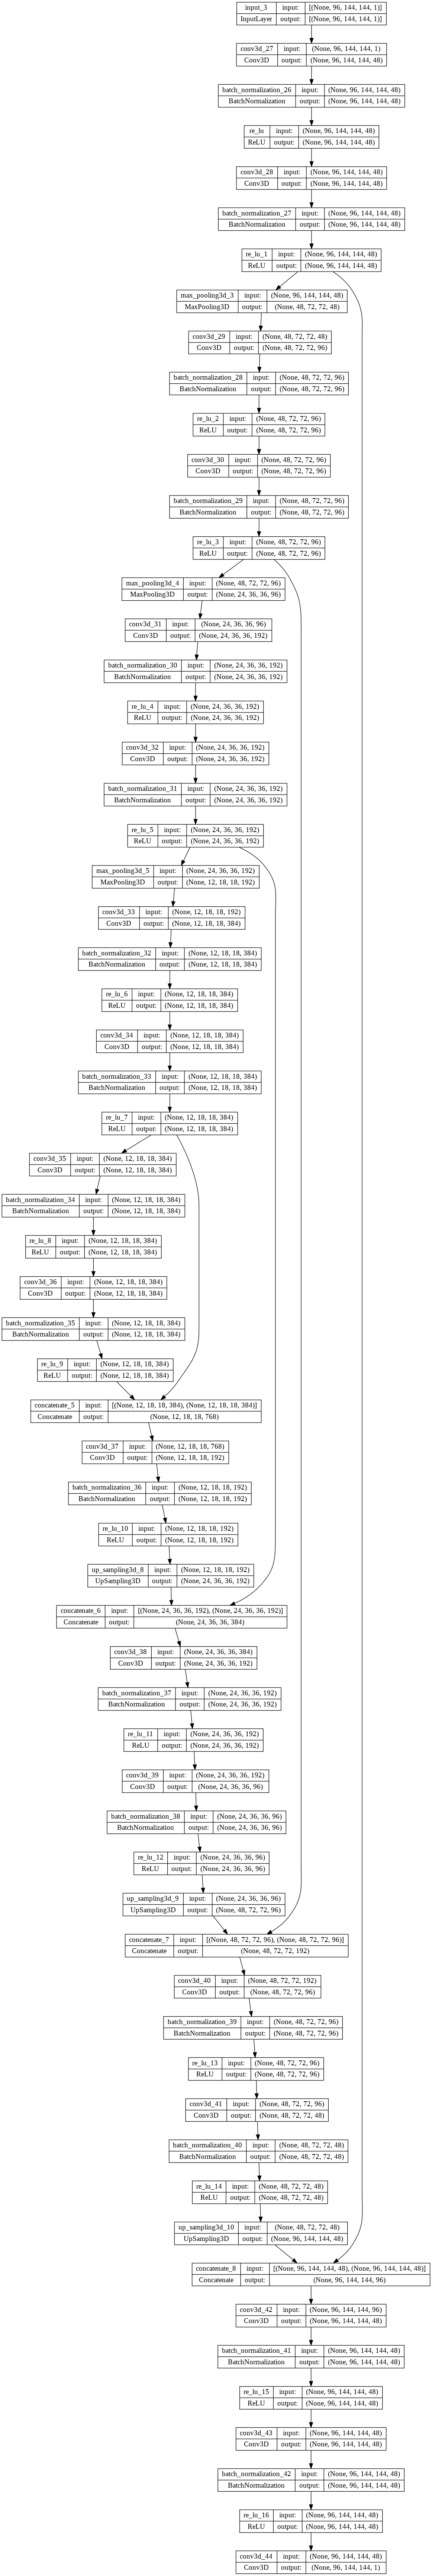

In [ ]:
tf.keras.utils.plot_model(model3, show_shapes=True)

Functionalized implementation of model with desired inputs by user for repeated calls, used later

In [ ]:
def MetaNetModel(input_size = (96, 144, 144, 1), no_of_filters = 48, filter_size = 3):
  
  inp = Input(shape = input_size)
  n, f = no_of_filters, filter_size

  conv1 = Conv3D(n, f, padding='same')(inp)
  conv1 = BatchNormalization()(conv1)
  conv1 = ReLU()(conv1)
  conv1 = Conv3D(n, f, padding='same')(conv1)
  conv1 = BatchNormalization()(conv1)
  conv1 = ReLU()(conv1)

  pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
  conv2 = Conv3D(2*n, f, padding='same')(pool1)
  conv2 = BatchNormalization()(conv2)
  conv2 = ReLU()(conv2)
  conv2 = Conv3D(2*n, f, padding='same')(conv2)
  conv2 = BatchNormalization()(conv2)
  conv2 = ReLU()(conv2)

  pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
  conv3 = Conv3D(4*n, f, padding='same')(pool2)
  conv3 = BatchNormalization()(conv3)
  conv3 = ReLU()(conv3)
  conv3 = Conv3D(4*n, f, padding='same')(conv3)
  conv3 = BatchNormalization()(conv3)
  conv3 = ReLU()(conv3)

  pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
  conv4 = Conv3D(8*n, f, padding='same')(pool3)
  conv4 = BatchNormalization()(conv4)
  conv4 = ReLU()(conv4)
  conv4 = Conv3D(8*n, f, padding='same')(conv4)
  conv4 = BatchNormalization()(conv4)
  conv4 = ReLU()(conv4)

  dil1 = Conv3D(8*n, f, dilation_rate=2, padding='same')(conv4)
  dil1 = BatchNormalization()(dil1)
  dil1 = ReLU()(dil1)
  dil1 = Conv3D(8*n, f, dilation_rate=2, padding='same')(dil1)
  dil1 = BatchNormalization()(dil1)
  dil1 = ReLU()(dil1)

  conc1 = Concatenate()([conv4, dil1])
  conv5 = Conv3D(4*n, f, padding='same')(conc1)
  conv5 = BatchNormalization()(conv5)
  conv5 = ReLU()(conv5)

  up1 = UpSampling3D(size=(2, 2, 2))(conv5)
  conc2 = Concatenate()([conv3, up1])
  conv6 = Conv3D(4*n, f, padding='same')(conc2)
  conv6 = BatchNormalization()(conv6)
  conv6 = ReLU()(conv6)
  conv6 = Conv3D(2*n, f, padding='same')(conv6)
  conv6 = BatchNormalization()(conv6)
  conv6 = ReLU()(conv6)

  up2 = UpSampling3D(size=(2, 2, 2))(conv6)
  conc3 = Concatenate()([conv2, up2])
  conv7 = Conv3D(2*n, f, padding='same')(conc3)
  conv7 = BatchNormalization()(conv7)
  conv7 = ReLU()(conv7)
  conv7 = Conv3D(n, f, padding='same')(conv7)
  conv7 = BatchNormalization()(conv7)
  conv7 = ReLU()(conv7)

  up3 = UpSampling3D(size=(2, 2, 2))(conv7)
  conc4 = Concatenate()([conv1, up3])
  conv8 = Conv3D(n, f, padding='same')(conc4)
  conv8 = BatchNormalization()(conv8)
  conv8 = ReLU()(conv8)
  conv8 = Conv3D(n, f, padding='same')(conv8)
  conv8 = BatchNormalization()(conv8)
  conv8 = ReLU()(conv8)

  out = Conv3D(1, 1, activation='sigmoid')(conv8)

  model = tf.keras.Model(inputs=inp, outputs=out)

  return model

###Experiments

In [ ]:
DataGen = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Training/',1,(96,144,144),modality='T1c')
X1, Y1 = DataGen.__getitem__(0)
X1.shape, Y1.shape

((1, 96, 144, 144), (1, 96, 144, 144))

In [ ]:
ValidGen = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Validation/',1,(96,144,144),modality='T1c')
X2, Y2 = ValidGen.__getitem__(0)
X2.shape, Y2.shape

((1, 96, 144, 144), (1, 96, 144, 144))

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.0001), loss=custom_loss.iou_loss, metrics = ['acc',precision,recall,f1score])

In [ ]:
history = model3.fit(DataGen,epochs=2,validation_data=ValidGen)

Epoch 1/2
220/220 [==============================] - 688s 3s/step - loss: 0.0227 - acc: 0.9890 - precision: 0.9914 - recall: 0.9853 - f1score: 0.9879 - val_loss: 0.4854 - val_acc: 0.4974 - val_precision: 0.4973 - val_recall: 1.0000 - val_f1score: 0.6634
Epoch 2/2
220/220 [==============================] - 632s 3s/step - loss: 0.0058 - acc: 0.9981 - precision: 0.9988 - recall: 0.9975 - f1score: 0.9981 - val_loss: 0.4922 - val_acc: 0.4992 - val_precision: 0.4982 - val_recall: 1.0000 - val_f1score: 0.6641


Redefine model3, compile and train with dice loss

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.0001), loss=custom_loss.dice_loss, metrics = ['acc',precision,recall,f1score])

In [ ]:
history2 = model3.fit(DataGen,epochs=2,validation_data=ValidGen)

Epoch 1/2
220/220 [==============================] - 637s 3s/step - loss: 0.0083 - acc: 0.9909 - precision: 0.9916 - recall: 0.9910 - f1score: 0.9913 - val_loss: 0.3187 - val_acc: 0.4977 - val_precision: 0.4974 - val_recall: 1.0000 - val_f1score: 0.6635
Epoch 2/2
220/220 [==============================] - 632s 3s/step - loss: 0.0020 - acc: 0.9980 - precision: 0.9987 - recall: 0.9974 - f1score: 0.9980 - val_loss: 0.3246 - val_acc: 0.5030 - val_precision: 0.5001 - val_recall: 1.0000 - val_f1score: 0.6659


Redefine model3, compile and train with binary cross entropy loss

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history3 = model3.fit(DataGen,epochs=2,validation_data=ValidGen)

Epoch 1/2
220/220 [==============================] - 638s 3s/step - loss: 0.0454 - acc: 0.9890 - precision: 0.9898 - recall: 0.9888 - f1score: 0.9892 - val_loss: 1.8257 - val_acc: 0.4977 - val_precision: 0.4974 - val_recall: 1.0000 - val_f1score: 0.6635
Epoch 2/2
220/220 [==============================] - 633s 3s/step - loss: 0.0187 - acc: 0.9978 - precision: 0.9983 - recall: 0.9974 - f1score: 0.9978 - val_loss: 2.2395 - val_acc: 0.5017 - val_precision: 0.4995 - val_recall: 1.0000 - val_f1score: 0.6653


Redefine model3, compile and train with binary focal cross entropy loss

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_focal_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history4 = model3.fit(DataGen,epochs=2,validation_data=ValidGen)

Epoch 1/2
220/220 [==============================] - 638s 3s/step - loss: 0.0063 - acc: 0.9921 - precision: 0.9935 - recall: 0.9901 - f1score: 0.9916 - val_loss: 0.5866 - val_acc: 0.4994 - val_precision: 0.4983 - val_recall: 1.0000 - val_f1score: 0.6642
Epoch 2/2
220/220 [==============================] - 633s 3s/step - loss: 0.0019 - acc: 0.9978 - precision: 0.9983 - recall: 0.9974 - f1score: 0.9978 - val_loss: 0.7533 - val_acc: 0.5245 - val_precision: 0.5113 - val_recall: 1.0000 - val_f1score: 0.6757


Best validation F1 and least training loss in 2nd epoch is observed for focal loss which is employed in further trainings

###Examples of experiments run in earlier notebooks

In [ ]:
#changing the model #experimentation with different image sizes and parameters for model1, however due to the issue, only capabilities could be tested
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_focal_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history1 = model1.fit(DataGen,epochs=2,validation_data=ValidGen)

Epoch 1/2
220/220 [==============================] - 94s 385ms/step - loss: 7.5906 - acc: 0.5022 - precision: 0.5022 - recall: 1.0000 - f1score: 0.6665 - val_loss: 7.6673 - val_acc: 0.4972 - val_precision: 0.4972 - val_recall: 1.0000 - val_f1score: 0.6633
Epoch 2/2
220/220 [==============================] - 86s 391ms/step - loss: 7.5906 - acc: 0.5022 - precision: 0.5022 - recall: 1.0000 - f1score: 0.6665 - val_loss: 7.6673 - val_acc: 0.4972 - val_precision: 0.4972 - val_recall: 1.0000 - val_f1score: 0.6633


model1/model2 has some issue as no training occurs with epochs

In [ ]:
#varying the learning rate
model3.compile(optimizer=Adam(learning_rate=0.01), loss='binary_focal_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history5 = model3.fit(DataGen,epochs=2,validation_data=ValidGen)

Epoch 1/2
220/220 [==============================] - 634s 3s/step - loss: 0.0101 - acc: 0.9870 - precision: 0.9869 - recall: 0.9880 - f1score: 0.9873 - val_loss: 2.2481 - val_acc: 0.4984 - val_precision: 0.4978 - val_recall: 1.0000 - val_f1score: 0.6638
Epoch 2/2
220/220 [==============================] - 628s 3s/step - loss: 0.0046 - acc: 0.9934 - precision: 0.9936 - recall: 0.9933 - f1score: 0.9934 - val_loss: 4.2514 - val_acc: 0.4991 - val_precision: 0.4982 - val_recall: 1.0000 - val_f1score: 0.6641


In [ ]:
inp = Input(shape=(96, 96, 96, 1))

conv1 = Conv3D(48, 3, padding='same')(inp)
conv1 = BatchNormalization()(conv1)
conv1 = ReLU()(conv1)
conv1 = Conv3D(48, 3, padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = ReLU()(conv1)

pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
conv2 = Conv3D(96, 3, padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = ReLU()(conv2)
conv2 = Conv3D(96, 3, padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = ReLU()(conv2)

pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
conv3 = Conv3D(192, 3, padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = ReLU()(conv3)
conv3 = Conv3D(192, 3, padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = ReLU()(conv3)

pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
conv4 = Conv3D(384, 3, padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = ReLU()(conv4)
conv4 = Conv3D(384, 3, padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = ReLU()(conv4)

dil1 = Conv3D(384, 3, dilation_rate=2, padding='same')(conv4)
dil1 = BatchNormalization()(dil1)
dil1 = ReLU()(dil1)
dil1 = Conv3D(384, 3, dilation_rate=2, padding='same')(dil1)
dil1 = BatchNormalization()(dil1)
dil1 = ReLU()(dil1)

conc1 = Concatenate()([conv4, dil1])
conv5 = Conv3D(192, 3, padding='same')(conc1)
conv5 = BatchNormalization()(conv5)
conv5 = ReLU()(conv5)

up1 = UpSampling3D(size=(2, 2, 2))(conv5)
conc2 = Concatenate()([conv3, up1])
conv6 = Conv3D(192, 3, padding='same')(conc2)
conv6 = BatchNormalization()(conv6)
conv6 = ReLU()(conv6)
conv6 = Conv3D(96, 3, padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = ReLU()(conv6)

up2 = UpSampling3D(size=(2, 2, 2))(conv6)
conc3 = Concatenate()([conv2, up2])
conv7 = Conv3D(96, 3, padding='same')(conc3)
conv7 = BatchNormalization()(conv7)
conv7 = ReLU()(conv7)
conv7 = Conv3D(48, 3, padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = ReLU()(conv7)

up3 = UpSampling3D(size=(2, 2, 2))(conv7)
conc4 = Concatenate()([conv1, up3])
conv8 = Conv3D(48, 3, padding='same')(conc4)
conv8 = BatchNormalization()(conv8)
conv8 = ReLU()(conv8)
conv8 = Conv3D(48, 3, padding='same')(conv8)
conv8 = BatchNormalization()(conv8)
conv8 = ReLU()(conv8)

out = Conv3D(1, 1, activation='sigmoid')(conv8)

model3 = tf.keras.Model(inputs=inp, outputs=out)
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_72 (Conv3D)             (None, 96, 96, 96,   1344        ['input_5[0][0]']                
                                48)                                                               
                                                                                                  
 batch_normalization_68 (BatchN  (None, 96, 96, 96,   192        ['conv3d_72[0][0]']              
 ormalization)                  48)                                                         

In [ ]:
#varying the batch size and image size
DataGen3 = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Training/',2,(96,96,96),'Flair')
ValidGen3 = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Validation/',2,(96,96,96),'Flair')
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_focal_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history12 = model3.fit(DataGen3,epochs=2,validation_data=ValidGen3)

Epoch 1/2
110/110 [==============================] - 269s 2s/step - loss: 0.0130 - acc: 0.9822 - precision: 0.9871 - recall: 0.9879 - f1score: 0.9871 - val_loss: 0.3368 - val_acc: 0.6729 - val_precision: 0.6729 - val_recall: 1.0000 - val_f1score: 0.8038
Epoch 2/2
110/110 [==============================] - 264s 2s/step - loss: 0.0033 - acc: 0.9958 - precision: 0.9970 - recall: 0.9968 - f1score: 0.9969 - val_loss: 0.5870 - val_acc: 0.6729 - val_precision: 0.6729 - val_recall: 1.0000 - val_f1score: 0.8038


###Training best model for different modalities

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_focal_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history6 = model3.fit(DataGen,epochs=5,validation_data=ValidGen)

Epoch 1/5
220/220 [==============================] - 637s 3s/step - loss: 0.0065 - acc: 0.9912 - precision: 0.9919 - recall: 0.9910 - f1score: 0.9914 - val_loss: 0.9639 - val_acc: 0.4982 - val_precision: 0.4977 - val_recall: 1.0000 - val_f1score: 0.6637
Epoch 2/5
220/220 [==============================] - 633s 3s/step - loss: 0.0016 - acc: 0.9982 - precision: 0.9985 - recall: 0.9978 - f1score: 0.9982 - val_loss: 1.4807 - val_acc: 0.5055 - val_precision: 0.5014 - val_recall: 1.0000 - val_f1score: 0.6670
Epoch 3/5
220/220 [==============================] - 633s 3s/step - loss: 0.0013 - acc: 0.9986 - precision: 0.9990 - recall: 0.9981 - f1score: 0.9986 - val_loss: 1.5610 - val_acc: 0.5087 - val_precision: 0.5031 - val_recall: 0.9999 - val_f1score: 0.6685
Epoch 4/5
220/220 [==============================] - 633s 3s/step - loss: 9.4916e-04 - acc: 0.9989 - precision: 0.9992 - recall: 0.9986 - f1score: 0.9989 - val_loss: 1.0239 - val_acc: 0.5279 - val_precision: 0.5134 - val_recall: 0.9999 - 

Overfitting after 4th epoch?

In [ ]:
model3.save('/content/drive/MyDrive/Model3/') # save the model

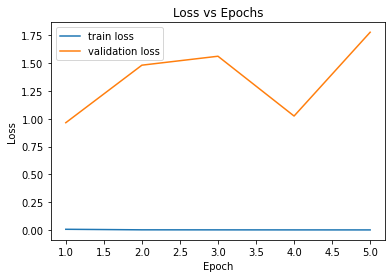

In [ ]:
epochs = range(1,6)
f_loss = history6.history["loss"]
val_f_loss = history6.history["val_loss"]
plt.plot(epochs, f_loss, label="train loss")
plt.plot(epochs, val_f_loss, label="validation loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

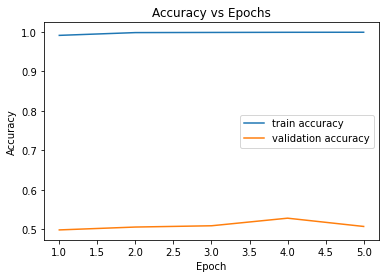

In [ ]:
accu = history6.history["acc"]
val_accu = history6.history["val_acc"]
plt.plot(epochs, accu, label="train accuracy")
plt.plot(epochs, val_accu, label="validation accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

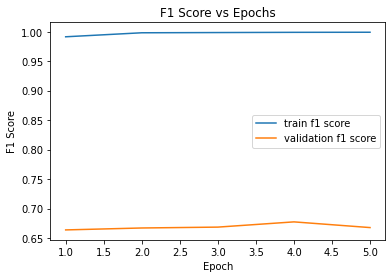

In [ ]:
f1 = history6.history["f1score"]
val_f1 = history6.history["val_f1score"]
plt.plot(epochs, f1, label="train f1 score")
plt.plot(epochs, val_f1, label="validation f1 score")
plt.title("F1 Score vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

In [ ]:
DataGen = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Training/',1,(96,144,144),'T1')
ValidGen = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Validation/',1,(96,144,144),'T1')
model4 = MetaNetModel()
model4.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_focal_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history7 = model4.fit(DataGen,epochs=5,validation_data=ValidGen)

Epoch 1/5
220/220 [==============================] - 710s 3s/step - loss: 0.0128 - acc: 0.9863 - precision: 0.9887 - recall: 0.9837 - f1score: 0.9859 - val_loss: 0.6735 - val_acc: 0.4991 - val_precision: 0.4981 - val_recall: 1.0000 - val_f1score: 0.6641
Epoch 2/5
220/220 [==============================] - 612s 3s/step - loss: 0.0060 - acc: 0.9946 - precision: 0.9960 - recall: 0.9936 - f1score: 0.9947 - val_loss: 0.4742 - val_acc: 0.6778 - val_precision: 0.6089 - val_recall: 0.9996 - val_f1score: 0.7553
Epoch 3/5
220/220 [==============================] - 611s 3s/step - loss: 0.0030 - acc: 0.9965 - precision: 0.9978 - recall: 0.9955 - f1score: 0.9966 - val_loss: 0.2904 - val_acc: 0.6112 - val_precision: 0.5661 - val_recall: 0.9981 - val_f1score: 0.7200
Epoch 4/5
220/220 [==============================] - 610s 3s/step - loss: 0.0048 - acc: 0.9957 - precision: 0.9971 - recall: 0.9944 - f1score: 0.9957 - val_loss: 0.5000 - val_acc: 0.5978 - val_precision: 0.5528 - val_recall: 0.9996 - val_

Overfitting after 2nd epoch!

In [ ]:
model4.save('/content/drive/MyDrive/Model4/')

In [ ]:
DataGen = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Training/',1,(96,144,144),'T2')
ValidGen = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Validation/',1,(96,144,144),'T2')
model5 = MetaNetModel()
model5.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_focal_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history8 = model5.fit(DataGen,epochs=5,validation_data=ValidGen)

Epoch 1/5
220/220 [==============================] - 738s 3s/step - loss: 0.0076 - acc: 0.9893 - precision: 0.9897 - recall: 0.9891 - f1score: 0.9892 - val_loss: 0.6794 - val_acc: 0.4978 - val_precision: 0.4976 - val_recall: 1.0000 - val_f1score: 0.6636
Epoch 2/5
220/220 [==============================] - 651s 3s/step - loss: 0.0021 - acc: 0.9974 - precision: 0.9980 - recall: 0.9968 - f1score: 0.9974 - val_loss: 0.8962 - val_acc: 0.5074 - val_precision: 0.5025 - val_recall: 1.0000 - val_f1score: 0.6679
Epoch 3/5
220/220 [==============================] - 651s 3s/step - loss: 0.0013 - acc: 0.9984 - precision: 0.9988 - recall: 0.9980 - f1score: 0.9984 - val_loss: 0.9119 - val_acc: 0.5174 - val_precision: 0.5077 - val_recall: 1.0000 - val_f1score: 0.6725
Epoch 4/5
220/220 [==============================] - 651s 3s/step - loss: 0.0012 - acc: 0.9986 - precision: 0.9990 - recall: 0.9982 - f1score: 0.9986 - val_loss: 1.1623 - val_acc: 0.5178 - val_precision: 0.5081 - val_recall: 0.9998 - val_

Overfitting after 4th epoch?

In [ ]:
model5.save('/content/drive/MyDrive/Model5/')

In [ ]:
DataGen = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Training/',1,(96,144,144),'Flair')
ValidGen = CustomDataGen('/content/drive/MyDrive/MetaNet_IE643_Dataset/Validation/',1,(96,144,144),'Flair')
model6 = MetaNetModel()
model6.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_focal_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history9 = model6.fit(DataGen,epochs=5,validation_data=ValidGen)

Epoch 1/5
220/220 [==============================] - 647s 3s/step - loss: 0.0075 - acc: 0.9898 - precision: 0.9898 - recall: 0.9923 - f1score: 0.9905 - val_loss: 1.3745 - val_acc: 0.4889 - val_precision: 0.4889 - val_recall: 1.0000 - val_f1score: 0.6551
Epoch 2/5
220/220 [==============================] - 618s 3s/step - loss: 0.0018 - acc: 0.9978 - precision: 0.9982 - recall: 0.9974 - f1score: 0.9978 - val_loss: 2.0491 - val_acc: 0.4930 - val_precision: 0.4909 - val_recall: 1.0000 - val_f1score: 0.6568
Epoch 3/5
220/220 [==============================] - 618s 3s/step - loss: 0.0012 - acc: 0.9986 - precision: 0.9990 - recall: 0.9982 - f1score: 0.9986 - val_loss: 1.2752 - val_acc: 0.5145 - val_precision: 0.5021 - val_recall: 0.9999 - val_f1score: 0.6666
Epoch 4/5
220/220 [==============================] - 618s 3s/step - loss: 0.0011 - acc: 0.9988 - precision: 0.9991 - recall: 0.9984 - f1score: 0.9988 - val_loss: 0.0062 - val_acc: 0.9937 - val_precision: 0.9913 - val_recall: 0.9962 - val_

Overfitting after 4th epoch?

In [ ]:
model6.save('/content/drive/MyDrive/Model6/')

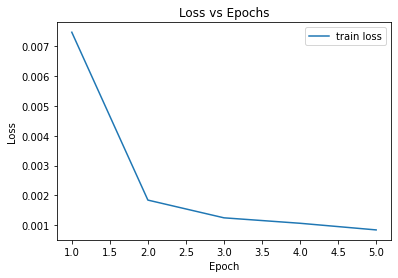

In [ ]:
epochs = range(1,6)
f_loss = history9.history["loss"]
val_f_loss = history9.history["val_loss"]
plt.plot(epochs, f_loss, label="train loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

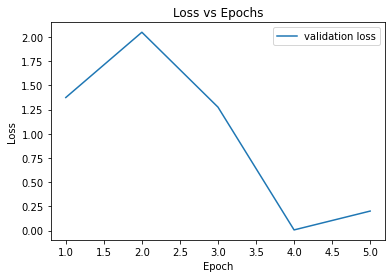

In [ ]:
epochs = range(1,6)
f_loss = history9.history["loss"]
val_f_loss = history9.history["val_loss"]
plt.plot(epochs, val_f_loss, label="validation loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

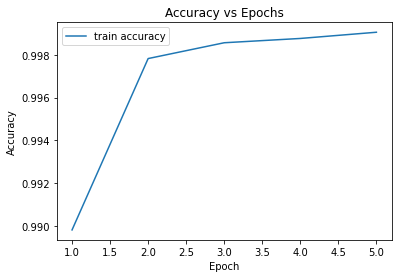

In [ ]:
accu = history9.history["acc"]
val_accu = history9.history["val_acc"]
plt.plot(epochs, accu, label="train accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

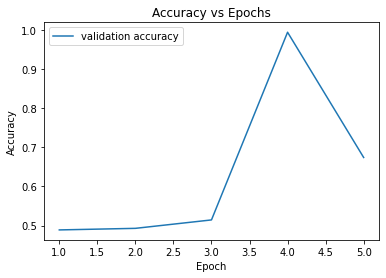

In [ ]:
accu = history9.history["acc"]
val_accu = history9.history["val_acc"]
plt.plot(epochs, val_accu, label="validation accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

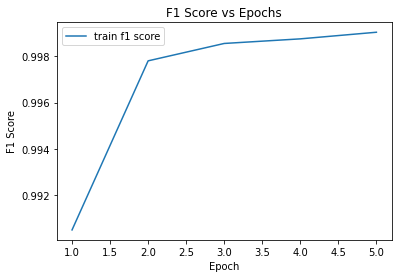

In [ ]:
f1 = history9.history["f1score"]
val_f1 = history9.history["val_f1score"]
plt.plot(epochs, f1, label="train f1 score")
plt.title("F1 Score vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

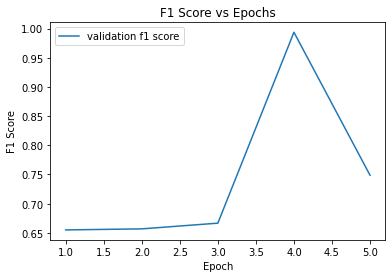

In [ ]:
f1 = history9.history["f1score"]
val_f1 = history9.history["val_f1score"]
plt.plot(epochs, val_f1, label="validation f1 score")
plt.title("F1 Score vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

##Tumor Classification

In [ ]:
class CustomDataGen2(tf.keras.utils.Sequence):
    
    def __init__(self, data_path, batch_size, input_size=(224, 224, 3), modality='all'):
        self.data_path = data_path
        self.batch_size = batch_size
        self.input_size = input_size
        self.modality = modality
        self.n = len(os.listdir(self.data_path+'/'+self.modality+'/'))

    def on_epoch_end(self):
        pass
    
    def input_process(self, img):
        img = img.astype('float32')
        img = img/255
        #img = (img-img.mean())/img.std()
        #img = tf.image.resize(img, self.input_size)
        #Crop Central part of image of size self.input_size
        img = img[:, img.shape[1]//2-self.input_size[1]//2:img.shape[1]//2+self.input_size[1]//2, img.shape[2]//2-self.input_size[2]//2:img.shape[2]//2+self.input_size[2]//2]
        #resize image in Z dimension
        img = np.resize(img, (self.input_size[0], img.shape[1], img.shape[2]))
        return img
    
    def output_process(self, img):
        img = img.astype('float32')
        #img = (img-img.mean())/img.std()
        #img = tf.image.resize(img, self.input_size)
        #Crop Central part of image of size self.input_size
        img = img[:, img.shape[1]//2-self.input_size[1]//2:img.shape[1]//2+self.input_size[1]//2, img.shape[2]//2-self.input_size[2]//2:img.shape[2]//2+self.input_size[2]//2]
        #resize image in Z dimension
        img = np.resize(img, (self.input_size[0], img.shape[1], img.shape[2]))
        im1, im2, im3, im4, im5 = img, img, img, img, img
        im1[im1 != 1] = 0
        im2[im2 != 2] = 0
        im2[im2 == 2] = 1
        im3[im3 != 3] = 0
        im3[im2 == 3] = 1
        im4[im4 != 4] = 0
        im4[im2 == 4] = 1
        imgx = [im1,im2,im3,im4]
        #Concatenate all the images
        return imgx

    def __getitem__(self, index):
        X = []
        Y = []
        if self.modality == 'all':
            X_temp = []
            imgs = os.listdir(self.data_path+'/T1/')
            batches = imgs[index*self.batch_size:(index+1)*self.batch_size]
            modalities = ['T1', 'T1c', 'T2', 'Flair']
            for i in range(len(batches)):
                for modality in modalities:
                    brain_name = self.data_path+'/'+modality+'/'+batches[i]
                    brain_img = sitk.ReadImage(brain_name)
                    brain_img = sitk.GetArrayFromImage(brain_img)
                    brain_img = self.input_process(brain_img)
                    X_temp.append(brain_img)
                X.append(X_temp)
                X_temp = []
                tumor_name = self.data_path+'/OT/'+batches[i]
                tumor_img = sitk.ReadImage(tumor_name)
                tumor_img = sitk.GetArrayFromImage(tumor_img)
                tumor_img = self.output_process(tumor_img)
                tumor_img = self.output_process(tumor_img)
                Y.append(tumor_img)
        else:
            imgs = os.listdir(self.data_path+'/'+self.modality+'/')
            batches = imgs[index*self.batch_size:(index+1)*self.batch_size]
            for i in range(len(batches)):
                brainname = self.data_path+self.modality+'/'+batches[i]
                tumorname = self.data_path+self.modality+'/'+batches[i]
                #print(brainname,tumorname)
                brain_img = sitk.ReadImage(brainname)
                brain_img = sitk.GetArrayFromImage(brain_img)
                brain_img = self.input_process(brain_img)
                tumor_img = sitk.ReadImage(tumorname)
                tumor_img = sitk.GetArrayFromImage(tumor_img)
                tumor_img = self.output_process(tumor_img)
                X.append(brain_img)
                Y.append(tumor_img)
                Yhat = np.array(Y)
        return np.expand_dims(np.array(X),-1), np.moveaxis(Yhat,1,-1)

    def __len__(self):
        return self.n // self.batch_size

In [ ]:
def MetaNetModel2(input_size = (96, 144, 144, 1), no_of_filters = 48, filter_size = 3):
  
  inp = Input(shape = input_size)
  n, f = no_of_filters, filter_size

  conv1 = Conv3D(n, f, padding='same')(inp)
  conv1 = BatchNormalization()(conv1)
  conv1 = ReLU()(conv1)
  conv1 = Conv3D(n, f, padding='same')(conv1)
  conv1 = BatchNormalization()(conv1)
  conv1 = ReLU()(conv1)

  pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
  conv2 = Conv3D(2*n, f, padding='same')(pool1)
  conv2 = BatchNormalization()(conv2)
  conv2 = ReLU()(conv2)
  conv2 = Conv3D(2*n, f, padding='same')(conv2)
  conv2 = BatchNormalization()(conv2)
  conv2 = ReLU()(conv2)

  pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
  conv3 = Conv3D(4*n, f, padding='same')(pool2)
  conv3 = BatchNormalization()(conv3)
  conv3 = ReLU()(conv3)
  conv3 = Conv3D(4*n, f, padding='same')(conv3)
  conv3 = BatchNormalization()(conv3)
  conv3 = ReLU()(conv3)

  pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
  conv4 = Conv3D(8*n, f, padding='same')(pool3)
  conv4 = BatchNormalization()(conv4)
  conv4 = ReLU()(conv4)
  conv4 = Conv3D(8*n, f, padding='same')(conv4)
  conv4 = BatchNormalization()(conv4)
  conv4 = ReLU()(conv4)

  dil1 = Conv3D(8*n, f, dilation_rate=2, padding='same')(conv4)
  dil1 = BatchNormalization()(dil1)
  dil1 = ReLU()(dil1)
  dil1 = Conv3D(8*n, f, dilation_rate=2, padding='same')(dil1)
  dil1 = BatchNormalization()(dil1)
  dil1 = ReLU()(dil1)

  conc1 = Concatenate()([conv4, dil1])
  conv5 = Conv3D(4*n, f, padding='same')(conc1)
  conv5 = BatchNormalization()(conv5)
  conv5 = ReLU()(conv5)

  up1 = UpSampling3D(size=(2, 2, 2))(conv5)
  conc2 = Concatenate()([conv3, up1])
  conv6 = Conv3D(4*n, f, padding='same')(conc2)
  conv6 = BatchNormalization()(conv6)
  conv6 = ReLU()(conv6)
  conv6 = Conv3D(2*n, f, padding='same')(conv6)
  conv6 = BatchNormalization()(conv6)
  conv6 = ReLU()(conv6)

  up2 = UpSampling3D(size=(2, 2, 2))(conv6)
  conc3 = Concatenate()([conv2, up2])
  conv7 = Conv3D(2*n, f, padding='same')(conc3)
  conv7 = BatchNormalization()(conv7)
  conv7 = ReLU()(conv7)
  conv7 = Conv3D(n, f, padding='same')(conv7)
  conv7 = BatchNormalization()(conv7)
  conv7 = ReLU()(conv7)

  up3 = UpSampling3D(size=(2, 2, 2))(conv7)
  conc4 = Concatenate()([conv1, up3])
  conv8 = Conv3D(n, f, padding='same')(conc4)
  conv8 = BatchNormalization()(conv8)
  conv8 = ReLU()(conv8)
  conv8 = Conv3D(n, f, padding='same')(conv8)
  conv8 = BatchNormalization()(conv8)
  conv8 = ReLU()(conv8)

  out = Conv3D(4, 1, activation='sigmoid')(conv8)

  model = tf.keras.Model(inputs=inp, outputs=out)

  return model

In [ ]:
DataGen2 = CustomDataGen2('/content/drive/MyDrive/MetaNet_IE643_Dataset/Training/',1,(96,144,144),'Flair')
X,Y = DataGen2.__getitem__(0)
X.shape, Y.shape

((1, 96, 144, 144, 1), (1, 96, 144, 144, 4))

In [ ]:
ValidGen2 = CustomDataGen2('/content/drive/MyDrive/MetaNet_IE643_Dataset/Validation/',1,(96,144,144),'Flair')
model7 = MetaNetModel2()
model7.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_focal_crossentropy', metrics = ['acc',precision,recall,f1score])

In [ ]:
history10 = model7.fit(DataGen2,epochs=2,validation_data=ValidGen2)

Epoch 1/2
220/220 [==============================] - 634s 3s/step - loss: 0.0512 - acc: 0.3943 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 0.0365 - val_acc: 0.6805 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 2/2
220/220 [==============================] - 626s 3s/step - loss: 0.0202 - acc: 0.3985 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 0.0158 - val_acc: 0.5318 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00


In [ ]:
model7.save('/content/drive/MyDrive/Model7/')